In [1]:
import numpy as np 
import pandas as pd 
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
import os
from keras.models import load_model

2023-01-08 08:14:39.402373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 08:14:40.352583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/teresababio/miniconda3/envs/core/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-08 08:14:40.352682: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-08 08:14:43.151792: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnv

In [2]:
labels = pd.read_csv('label_names.csv')
print(labels.head())
print()

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)



In [3]:
model = load_model('../datos/modelos_finales/model_cnn.h5')
with open('mean_image_rgb.pickle', 'rb') as f:
    mean = pickle.load(f, encoding='latin1')  # dictionary type

2023-01-08 08:14:45.929304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/teresababio/miniconda3/envs/core/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-08 08:14:45.929953: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-08 08:14:45.930624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-FNGN17J8): /proc/driver/nvidia/version does not exist
2023-01-08 08:14:45.933081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow wit

In [4]:
# Los pesos del modelo de deteccion
path_to_weights = 'yolov3_ts_train_5000.weights'
path_to_cfg = 'yolov3_ts_test.cfg'

# Cargando el modelo entrenado con YOLO v3
network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)

network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16)

In [5]:
# Nombre de todas las capas YOLO v3
layers_all = network.getLayerNames()


# Imprimimos solo las capas de deteccion YOLO v3: 82, 94 y 106
layers_names_output = [layers_all[i - 1] for i in network.getUnconnectedOutLayers()]

# Check point
print()
print(layers_names_output)  # ['yolo_82', 'yolo_94', 'yolo_106']


['yolo_82', 'yolo_94', 'yolo_106']


In [6]:
# Minima prob. para eliminar detecciones
probability_minimum = 0.2

#Setting threshold to filtering weak bounding boxes by non-maximum suppression
threshold = 0.2

# Generando colores para bounding boxes
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

print(type(colours)) 
print(colours.shape)  
print(colours[0])  

<class 'numpy.ndarray'>
(43, 3)
[102  81 126]


In [7]:
#video = cv2.VideoCapture('traffic-sign-to-test.mp4')
video = cv2.VideoCapture("Vídeo curso autoescuela_ Señales de reglamentacion. Prioridad_Trim.mp4")
# Writerque se usará para el procesado de frames
writer = None

# Variables para las dimenciones espaciales de los frames
h, w = None, None

In [8]:
%matplotlib inline

# Setting default size of plots
plt.rcParams['figure.figsize'] = (3, 3)

# Variable for counting total amount of frames
f = 0

# Variable for counting total processing time
t = 0

# Catching frames in the loop
while True:
    # Capturing frames one-by-one
    ret, frame = video.read()

    # If the frame was not retrieved
    if not ret:
        break
       
    # Getting spatial dimensions of the frame for the first time
    if w is None or h is None:
        # Slicing two elements from tuple
        h, w = frame.shape[:2]

    # Blob from current frame
    blob = cv2.dnn.blobFromImage(cv2.cvtColor(frame,  cv2.COLOR_BGR2RGB), 1 / 255.0, (416, 416), swapRB=True, crop=False)

    # Forward pass with blob through output layers
    network.setInput(blob)
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end = time.time()

    # Increasing counters
    f += 1
    t += end - start

    # Spent time for current frame
    print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

    # Lists for detected bounding boxes, confidences and class's number
    bounding_boxes = []
    confidences = []
    #class_numbers = []

    # Going through all output layers after feed forward pass
    for result in output_from_network:
        # Going through all detections from current output layer
        for detected_objects in result:
            # Getting 80 classes' probabilities for current detected object
            scores = detected_objects[5:]
            # Getting index of the class with the maximum value of probability
            class_current = np.argmax(scores)
            # Getting value of probability for defined class
            confidence_current = scores[class_current]

            # Eliminating weak predictions by minimum probability
            if confidence_current > probability_minimum:
                # Scaling bounding box coordinates to the initial frame size
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Getting top left corner coordinates
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adding results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                #class_numbers.append(class_current)
                

    # Implementing non-maximum suppression of given bounding boxes
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    # Checking if there is any detected object been left
    if len(results) > 0:
        # Going through indexes of results
        for i in results.flatten():
            # Bounding box coordinates, its width and height
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
            # Cut fragment with Traffic Sign
            c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
            # print(c_ts.shape)
            
            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:
                # Getting preprocessed blob with Traffic Sign of needed shape
                blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
                #blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
                blob_ts = blob_ts.transpose(0, 2, 3, 1)


                # Feeding to the Keras CNN model to get predicted label among 43 classes
                scores = model.predict(blob_ts)

                # Scores is given for image with 43 numbers of predictions for each class
                # Getting only one class with maximum value
                prediction = np.argmax(scores)
                # print(labels['SignName'][prediction])


                # Colour for current bounding box
                colour_box_current = colours[prediction].tolist()

                # Drawing bounding box on the original current frame
                cv2.rectangle(frame, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)

                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
                                                       confidences[i])
                # Putting text with label and confidence on the original image
                cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)


    # Initializing writer only once
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')

        # Writing current processed frame into the video file
        writer = cv2.VideoWriter('result.mp4', fourcc, 25,
                                 (frame.shape[1], frame.shape[0]), True)

    # Write processed current frame to the file
    writer.write(frame)


# Releasing video reader and writer
video.release()
writer.release()

[ WARN:0@9.336] global /io/opencv/modules/dnn/src/net_impl.cpp (154) setUpNet DNN: OpenCL target is not supported with current OpenCL device (tested with GPUs only), switching to CPU.


Frame number 1 took 4.36211 seconds
1/1 [==============================] - 0s 460ms/step
Frame number 2 took 1.96935 seconds
1/1 [==============================] - 0s 39ms/step
Frame number 3 took 1.72094 seconds
1/1 [==============================] - 0s 39ms/step
Frame number 4 took 1.57274 seconds
1/1 [==============================] - 0s 54ms/step
Frame number 5 took 2.57466 seconds
1/1 [==============================] - 0s 54ms/step
Frame number 6 took 1.53774 seconds
1/1 [==============================] - 0s 30ms/step
Frame number 7 took 1.83029 seconds
1/1 [==============================] - 0s 30ms/step
Frame number 8 took 2.00119 seconds
1/1 [==============================] - 0s 38ms/step
Frame number 9 took 1.54897 seconds
1/1 [==============================] - 0s 33ms/step
Frame number 10 took 1.88518 seconds
1/1 [==============================] - 0s 62ms/step
Frame number 11 took 1.56273 seconds
1/1 [==============================] - 0s 39ms/step
Frame number 12 took 1.54749 


KeyboardInterrupt



In [ ]:
print('Total number of frames', f)
print('Total amount of time {:.5f} seconds'.format(t))
print('FPS:', round((f / t), 1))

# Saving locally without committing
from IPython.display import FileLink

FileLink('result2.mp4')

In [ ]:
frame_array

array([], dtype=float64)

In [2]:
video = cv2.VideoCapture("Vídeo curso autoescuela_ Señales de reglamentacion. Prioridad_Trim.mp4")
a,r = video.read()

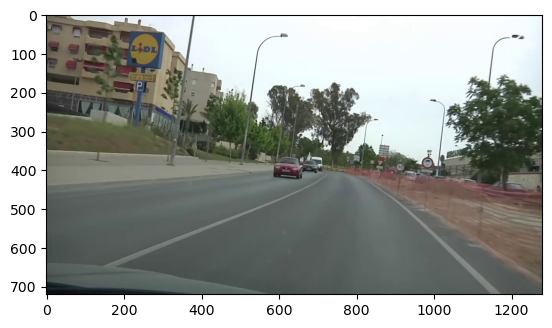

In [5]:
plt.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))

## Procesando Imagen 

In [ ]:
# Variable for counting total processing time
t = 0

# Blob from current frame
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Forward pass with blob through output layers
network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Time
t += end - start
print('Total amount of time {:.5f} seconds'.format(t))

# Lists for detected bounding boxes, confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

# Going through all output layers after feed forward pass
for result in output_from_network:
    # Going through all detections from current output layer
    for detected_objects in result:
        # Getting 80 classes' probabilities for current detected object
        scores = detected_objects[5:]
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(scores)
        # Getting value of probability for defined class
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial frame size
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            # Getting top left corner coordinates
            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
                

# Implementing non-maximum suppression of given bounding boxes
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Checking if there is any detected object been left
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Bounding box coordinates, its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
        # Cut fragment with Traffic Sign
        c_ts = image_BGR[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
        # print(c_ts.shape)
            
        if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
            pass
        else:
            # Getting preprocessed blob with Traffic Sign of needed shape
            blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
            blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
            blob_ts = blob_ts.transpose(0, 2, 3, 1)
            # plt.imshow(blob_ts[0, :, :, :])
            # plt.show()

            # Feeding to the Keras CNN model to get predicted label among 43 classes
            scores = model.predict(blob_ts)

            # Scores is given for image with 43 numbers of predictions for each class
            # Getting only one class with maximum value
            prediction = np.argmax(scores)
            print(labels['SignName'][prediction])


            # Colour for current bounding box
            colour_box_current = colours[class_numbers[i]].tolist()
            
            # Green BGR
            colour_box_current = [0, 255, 61]
            
            # Yellow BGR
#             colour_box_current = [0, 255, 255]

            # Drawing bounding box on the original current frame
            cv2.rectangle(image_BGR, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 6)

#             # Preparing text with label and confidence for current bounding box
#             text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
#                                                    confidences[i])
            
#             # Putting text with label and confidence on the original image
#             cv2.putText(image_BGR, text_box_current, (x_min, y_min - 15),
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
            
            if prediction == 5:
                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format('Speed limit 60', confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(image_BGR, text_box_current, (x_min - 110, y_min - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
                
            elif prediction == 9:            
                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format('No overtaking', confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(image_BGR, text_box_current, (x_min - 110, y_min + box_height + 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)

#             elif prediction == 17:            
#                 # Preparing text with label and confidence for current bounding box
#                 text_box_current = '{}: {:.4f}'.format('No entry', confidences[i])

#                 # Putting text with label and confidence on the original image
#                 cv2.putText(image_BGR, text_box_current, (x_min - 170, y_min - 15),
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
                
                
# Saving image
cv2.imwrite('result.png', image_BGR)